In [3]:
import shutil 
import os
import pandas as pd

In [4]:
import os
import copy
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm
import glob
import numpy as np
import tensorflow as tf
from skimage.io import imread, imsave
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix
from sklearn import svm
from PIL import Image
import random

import tensorflow_datasets as tfds
from tensorflow.keras import layers

In [5]:
train_dataset = '/Users/ericyao/Documents/AARD/Lung/archive/raw2_png/Training'
testing_dataset = '/Users/ericyao/Documents/AARD/Lung/archive/raw2_png/Testing'

In [6]:
data= pd.read_csv("metadata3.csv")
data

,Filename,StudyDate,BrixiaScoreGlobal,Subject,StudyId,Sex,AgeAtStudyDateFiveYear
0,15626316918619298757.png,20200403,1,P2255,A0000,M,11
1,14564261561865340756.png,20200406,2,P2291,A0001,M,8
2,3030367955559789319.png,20200405,1,P2272,A0002,M,11
3,10548672632742803246.png,20200408,3,P2299,A0003,M,12
4,434139174381164494.png,20200409,2,P2076,A0004,M,8
...,...,...,...,...,...,...,...
4690,10409101678672828001.png,20200314,1,P1071,A4582,M,10
4691,282205201992683717.png,20200318,10,P1071,A4583,M,10
4692,9504330565338059035.png,20200322,15,P0193,A4584,M,14
4693,8824145367570793429.png,20200331,16,P0193,A4585,M,14


In [7]:
img_paths = glob.glob(os.path.join(train_dataset, '*/*.png'))
parent_names = [os.path.basename(os.path.abspath(os.path.join(p, os.pardir))) for p in img_paths]
labels = np.asarray([1 if p == '1' else 2 if p == '2' 
                    else 3 for p in parent_names])
imgs = np.asarray([imread(p) for p in img_paths])
len(img_paths)

90

In [8]:
x_train, x_test, y_train, y_test = train_test_split(imgs, labels, test_size = 0.25, random_state = 1)

In [9]:
y_test

array([3, 2, 3, 3, 2, 2, 2, 3, 3, 3, 3, 3, 2, 1, 3, 2, 1, 1, 2, 2, 3, 1,
       2])

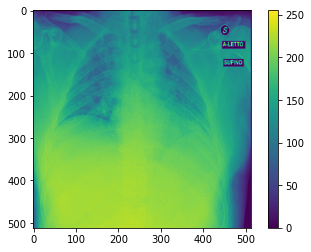

In [34]:
plt.figure()
plt.imshow(x_train[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [2]:
import tensorflow as tf
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16,(3,3),activation = "relu" , input_shape = (512,512,3)) ,
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32,(3,3),activation = "relu") ,  
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation = "relu") ,  
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128,(3,3),activation = "relu"),  
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(3,activation = "softmax")  
])

2022-08-20 19:17:21.266402: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 510, 510, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 255, 255, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 253, 253, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 126, 126, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 64)      18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 62, 62, 64)       0

In [43]:
bs=32       
train_dir = "/Users/ericyao/Documents/AARD/Lung/archive/raw2_png/Training" 
validation_dir = "/Users/ericyao/Documents/AARD/Lung/archive/raw2_png/Testing"   
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

train_datagen = ImageDataGenerator( 
    rotation_range=20,
    brightness_range=[0.2,1.0],
    rescale = 1.0/512.
    )

test_datagen  = ImageDataGenerator( rescale = 1.0/512. )

train_generator=train_datagen.flow_from_directory(train_dir,batch_size=bs,class_mode='categorical',target_size=(512,512))

validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=bs,
                                                         class_mode  = 'categorical',
                                                         target_size=(512,512))

Found 90 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


In [46]:
from tensorflow.keras.optimizers import RMSprop,SGD,Adam
adam=Adam(lr=0.00001)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['acc'])

In [40]:
import math

In [41]:
compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / 32))

steps_per_epoch = compute_steps_per_epoch(90)
val_steps = compute_steps_per_epoch(60)

In [ ]:
history = model.fit(train_generator, train_labels, epochs=10)

In [47]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=10,
                    validation_steps= val_steps)

Epoch 1/10
3/3 [==============================] - 22s 6s/step - loss: 1.2580 - acc: 0.2889 - val_loss: 1.1367 - val_acc: 0.4167
Epoch 2/10
3/3 [==============================] - 19s 6s/step - loss: 1.0796 - acc: 0.4667 - val_loss: 1.0911 - val_acc: 0.5167
Epoch 3/10
3/3 [==============================] - 19s 6s/step - loss: 1.0904 - acc: 0.4000 - val_loss: 1.0604 - val_acc: 0.5500
Epoch 4/10
3/3 [==============================] - 19s 6s/step - loss: 1.0540 - acc: 0.4222 - val_loss: 0.9874 - val_acc: 0.6333
Epoch 5/10
3/3 [==============================] - 19s 6s/step - loss: 0.9652 - acc: 0.6222 - val_loss: 0.8347 - val_acc: 0.6833
Epoch 6/10
3/3 [==============================] - 19s 6s/step - loss: 0.8201 - acc: 0.6778 - val_loss: 0.7648 - val_acc: 0.6667
Epoch 7/10
3/3 [==============================] - 18s 6s/step - loss: 0.7510 - acc: 0.6444 - val_loss: 1.0635 - val_acc: 0.4833
Epoch 8/10
3/3 [==============================] - 18s 5s/step - loss: 0.7496 - acc: 0.6556 - val_loss: 1

In [48]:
scores = model.predict(validation_generator, verbose = 1)

2/2 [==============================] - 3s 1s/step


In [49]:
model.evaluate(validation_generator, verbose = 1)

2/2 [==============================] - 3s 1s/step - loss: 1.0631 - acc: 0.6167


[1.0630933046340942, 0.6166666746139526]

In [50]:
preds = np.argmax(scores, axis = 1)

In [51]:
preds 

array([2, 0, 0, 2, 0, 2, 2, 0, 0, 2, 1, 0, 1, 0, 0, 0, 0, 2, 1, 2, 1, 0,
       1, 1, 2, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 2, 0, 2, 1, 2, 1, 1, 0, 2,
       2, 1, 1, 0, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1])

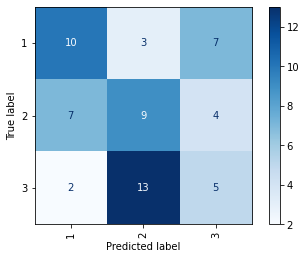

In [52]:
matrix = confusion_matrix(validation_generator.classes, preds)
disp = ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = train_generator.class_indices)
disp = disp.plot(cmap = plt.cm.Blues)
plt.xticks(rotation = 90)
plt.show()

In [55]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[0].set(xlim=(0, 10), ylim=(0, 2))
    ax[0].set_xlabel('Epochs')
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[1].set(xlim=(0, 10), ylim=(0, 1))
    ax[1].set_xlabel('Epochs')
    ax[0].legend()
    ax[1].legend()

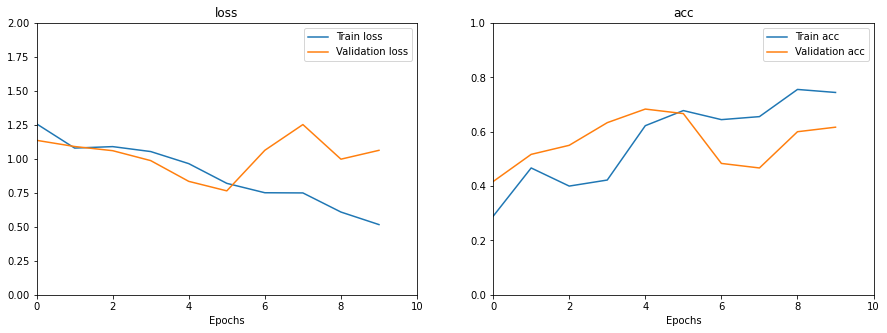

In [56]:
show_final_history(history)
